In [1]:
import folium
import numpy as np
import pandas as pd
import commonFunctions as func
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import commonFunctions as func
from geopy.distance import geodesic
import os

In [7]:
'''
Finds the closest summits to a given latitude-longitude point
Used to find the index of a point I want to investigate
'''
def findClosestSummitsToPoint(latitude, longitude, summits, num=3):
    summitsCopy = summits.copy()
    summitsCopy['distance'] = summitsCopy.apply(lambda peak: func.geod.line_length([peak.longitude, longitude], 
                                                                                   [peak.latitude, latitude]), axis=1)
    summitsCopy['distance'] = summitsCopy.distance.divide(1000).round(2)
    summitsCopy = summitsCopy[['id', 'latitude', 'longitude', 'elevation', 'distance']]
    print(summitsCopy.nsmallest(num, 'distance').head(num))
    
params = func.getParameters()
# patchDir = params['patch_directory']
patchDir = '../dataSources/generatedDatasets/prominencePatches'
# patchDir = '../dataSources/generatedDatasets/isolationPatches'
patchSize = int(params['patch_size'])
poleLat = func.getPoleLatitude(patchSize)
hasIsolation = eval(params['has_isolation'])
hasIsolation = False

if hasIsolation:
    columnNames = ['id', 'latitude', 'longitude', 'elevation', 'MHD', 'isolation']
else:
    columnNames = ['id', 'latitude', 'longitude', 'elevation', 'MHD']
    
latitudeToTest, longitudeToTest = 44.998, 6.331
summits = pd.DataFrame(func.getPatchSummits(latitudeToTest, longitudeToTest, patchDir, patchSize, poleLat), columns = columnNames)
findClosestSummitsToPoint(latitudeToTest, longitudeToTest, summits)

           id  latitude  longitude  elevation  distance
119  605139.0   44.9981     6.3300    3785.55      0.08
131  610033.0   44.9992     6.3244    3766.02      0.54
96   590627.0   45.0039     6.3186    3842.17      1.18


In [5]:
observer = func.Summit(42.41455, 2.13339, 2820) #42.4144     2.1333    2821.78
target = func.Summit(44.998, 6.331, 3881) #44.9981     6.3300    3785.55
los = func.LineOfSight(observer, target, sampleDist=0.1, forceFull=True)

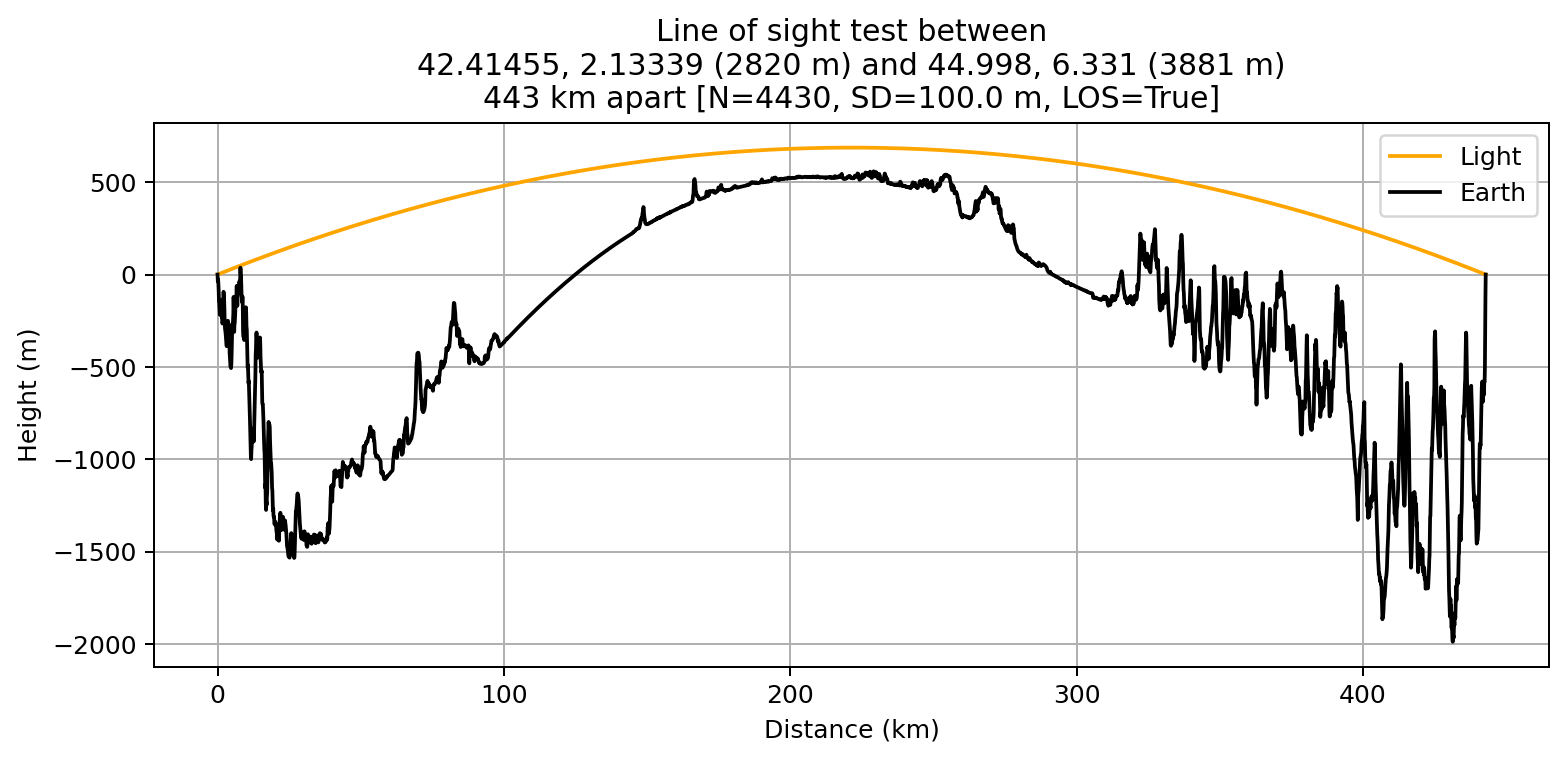

In [6]:
# los.process()
los.plot()

In [2]:
outputFile = f'../dataSources/generatedDatasets/longestLOS_5.6_0.1.txt'
if os.path.exists(outputFile):
    linesOfSight = pd.read_csv(outputFile)
    
# Sort LOS by distance (farthest first)
linesOfSight = linesOfSight.sort_values('distance', ascending=False)
print(len(linesOfSight))

264


In [3]:
# Only consider LOS where it's the longest LOS for both summits
accountedForLocations = set()
filteredLinesOfSight = []
for i, lineOfSight in linesOfSight.iterrows():
    
    targetLocation = (lineOfSight['latitude_T'], lineOfSight['longitude_T'])
    observerLocation = (lineOfSight['latitude_O'], lineOfSight['longitude_O'])

    # The observer or target being included in a longer LOS disqualifies this LOS
    if targetLocation in accountedForLocations or observerLocation in accountedForLocations:
        accountedForLocations.add(targetLocation)
        accountedForLocations.add(observerLocation)
        continue

    filteredLinesOfSight.append(lineOfSight)
    accountedForLocations.add(targetLocation)
    accountedForLocations.add(observerLocation)

linesOfSight = pd.DataFrame(filteredLinesOfSight)
print(len(linesOfSight))

51


In [10]:
from geographiclib.geodesic import Geodesic

def getLosColor(elevation):
    
    # Defining colors for colormap
    colors = [
        (0.00, 'limegreen'),
        (0.25, 'yellow'),
        (0.50, 'orange'),
        (0.75, 'red'),
        (1.00, 'indigo')
    ]

    # Create the colormap
    colormap = LinearSegmentedColormap.from_list('custom_colormap', colors)
    rgbaColor = colormap((elevation-func.losDistanceCutOff)/(linesOfSight.distance.max()-func.losDistanceCutOff))
    
    # Convert RGBA to HEX
    hexColor = "#{:02x}{:02x}{:02x}".format(
        int(rgbaColor[0] * 255), # Red
        int(rgbaColor[1] * 255), # Green
        int(rgbaColor[2] * 255)  # Blue
    )
    
    return hexColor
    
def addLosToMap(los):
    
    greatCircle = greatCirclePath(los.latitude_O, los.longitude_O, los.latitude_T, los.longitude_T)
    
    folium.PolyLine(greatCircle, color=getLosColor(los.distance), weight=4, opacity=1).add_to(pinnaclePointMap)
    
    folium.RegularPolygonMarker(
        location=[los.latitude_T, los.longitude_T],
        number_of_sides=3,
        rotation=30,
        radius=6.5,
        color=getLosColor(los.distance),
        fill=True,
        fill_color='black',
        fill_opacity=1
    ).add_to(pinnaclePointMap)
    
    folium.RegularPolygonMarker(
        location=[los.latitude_O, los.longitude_O],
        number_of_sides=3,
        rotation=30,
        radius=6.5,
        color=getLosColor(los.distance),
        fill=True,
        fill_color='black',
        fill_opacity=1
    ).add_to(pinnaclePointMap)
    
    losText = (f'Line of sight is <b>{round(los.distance/1000, 1)} km</b> from<br>' 
               + f'{los.latitude_O}, {los.longitude_O} ({round(los.elevation_O)} m) to<br>' 
               + f'{los.latitude_T}, {los.longitude_T} ({round(los.elevation_T)} m)')
    
    folium.PolyLine(greatCircle, color=getLosColor(los.distance), weight=24, opacity=0, 
                    popup=folium.Popup(losText, max_width=200)).add_to(pinnaclePointMap)
    
    invisibleCircleO = folium.CircleMarker(
        location = [los.latitude_O, los.longitude_O],
        radius = 12,
        fill = True,
        fill_opacity = 0,
        weight = 0
    ).add_to(pinnaclePointMap)
    
    
    azimuthFwd, azimuthBack, distance = func.geod.inv(los.longitude_O, los.latitude_O, los.longitude_T, los.latitude_T)
    
    sweep = 60
    
    leftboundFwd = azimuthFwd - sweep/2
    if leftboundFwd < -180:
        leftboundFwd += 360 
        
    rightboundFwd = azimuthFwd + sweep/2
    if rightboundFwd > 180:
        rightboundFwd -= 360
        
    leftboundBack = azimuthBack - sweep/2
    if leftboundBack < -180:
        leftboundBack += 360 
        
    rightboundBack = azimuthBack + sweep/2
    if rightboundBack > 180:
        rightboundBack -= 360
        
    panoramaDistance = round(los.distance/1000 * 1.05)
    panoramaZoom = 10
        
    toolTipO = (f'Location: {los.latitude_O}, {los.longitude_O}<br>' 
                + f'Elevation: {round(los.elevation_O)} m<br>'
                + f'Prominence: {round(los.prominence_O)} m<br>'
                + f'<li><a href=https://www.google.com/maps?q={los.latitude_O},{los.longitude_O}>Google Maps</a></li>' 
                + f'<li><a href=https://www.peakbagger.com/search.aspx?tid=R&lat={los.latitude_O}&lon={los.longitude_O}&ss=>PeakBagger</a></li>' 
                + f'<li><a href=https://www.udeuschle.de/panoramas/panqueryfull.aspx?mode=newstandard&data=lon:{los.longitude_O}$$$lat:{los.latitude_O}$$$' 
                + f'alt:auto$$$altcam:2$$$hialt:true$$$resolution:20$$$azimut:{azimuthFwd}$$$sweep:{sweep}$$$leftbound:{leftboundFwd}$$$rightbound:{rightboundFwd}$$$split:60$$$' 
                + f'splitnr:{panoramaZoom}$$$tilt:auto$$$tiltsplit:false$$$elexagg:1.0$$$range:{panoramaDistance}$$$colorcoding:false$$$colorcodinglimit:107$$$'
                + f'title:Panorama%20from%20{los.latitude_O},%20{los.longitude_O}$$$description:$$$email:$$$' 
                + f'language:en$$$screenwidth:1280$$$screenheight:777>U. Deuschle Panorama</a></li>')

    invisibleCircleO.add_child(folium.Popup(toolTipO, max_width=300).add_to(invisibleCircleO))
    
    invisibleCircleT = folium.CircleMarker(
        location = [los.latitude_T, los.longitude_T],
        radius = 12,
        fill = True,
        fill_opacity = 0,
        weight = 0
    ).add_to(pinnaclePointMap)  

    toolTipT = (f'Location: {los.latitude_T}, {los.longitude_T}<br>' 
                + f'Elevation: {round(los.elevation_T)} m<br>'
                + f'Prominence: {round(los.prominence_T)} m<br>'
                + f'<li><a href=https://www.google.com/maps?q={los.latitude_T},{los.longitude_T}>Google Maps</a></li>' 
                + f'<li><a href=https://www.peakbagger.com/search.aspx?tid=R&lat={los.latitude_T}&lon={los.longitude_T}&ss=>PeakBagger</a></li>' 
                + f'<li><a href=https://www.udeuschle.de/panoramas/panqueryfull.aspx?mode=newstandard&data=lon:{los.longitude_T}$$$lat:{los.latitude_T}$$$' 
                + f'alt:auto$$$altcam:2$$$hialt:true$$$resolution:20$$$azimut:{azimuthBack}$$$sweep:{sweep}$$$leftbound:{leftboundBack}$$$rightbound:{rightboundBack}$$$split:60$$$' 
                + f'splitnr:{panoramaZoom}$$$tilt:auto$$$tiltsplit:false$$$elexagg:1.0$$$range:{panoramaDistance}$$$colorcoding:false$$$colorcodinglimit:107$$$'
                + f'title:Panorama%20from%20{los.latitude_T},%20{los.longitude_T}$$$description:$$$email:$$$' 
                + f'language:en$$$screenwidth:1280$$$screenheight:777>U. Deuschle Panorama</a></li>')

    invisibleCircleT.add_child(folium.Popup(toolTipT, max_width=300).add_to(invisibleCircleT))
            
def greatCirclePath(observerLatitude, observerLongitude, targetLatitude, targetLongitude, numPoints=6):
    
    line = Geodesic.WGS84.InverseLine(observerLatitude, observerLongitude, targetLatitude, targetLongitude)

    pathPoints = []
    for i in np.linspace(0, line.s13, numPoints):
        point = line.Position(i)
        pathPoints.append((point['lat2'], point['lon2']))
    
    return pathPoints
                        
pinnaclePointMap = folium.Map(location=[0, 0], zoom_start=3, tiles=None, world_copy_jump=True)

legend_html = """
    <div style="
        background-color: rgba(255, 255, 255, 0.9);
        padding: 5px;
        font-size: 12px;
        position: absolute;
        top: 12px;
        right: 70px;
        z-index: 1000;
    ">
        <div style="display: flex; align-items: center; cursor: pointer;" title="Legend" onclick="toggleLegend()">
            <div id="chevronIcon" style="margin-left: 11px; margin-right: 15px; width: 10px; height: 10px; 
                border-style: solid; border-width: 0 3px 3px 0; transform: rotate(45deg);"></div>
            <center><h4 style="margin: 0; margin-right: 30px;"><b>Longest<br>Lines of Sight</b></h4></center>
        </div>
        <div id="legendContent" style="display: none; margin-top: 5px;">
            <div style="margin-top: 15px; margin-bottom: 15px; margin-left: 20px;">
                The farthest pairs of points<br>that can see each other.<br>More in the info section.
            </div>
             <center>
                 <div><b>Line of Sight Length</b></div>
                 <svg width="160" height="20">
                      <defs>
                        <linearGradient id="grad1" x1="0%" y1="0%" x2="100%" y2="0%">
                            <stop offset="0%" style="stop-color: limegreen; stop-opacity: 1" />
                            <stop offset="25%" style="stop-color: yellow; stop-opacity: 1" />
                            <stop offset="50%" style="stop-color: orange; stop-opacity: 1" />
                            <stop offset="75%" style="stop-color: red; stop-opacity: 1" />
                            <stop offset="100%" style="stop-color: indigo; stop-opacity: 1" />
                        </linearGradient>
                    </defs>
                    <line x1="0" y1="10.01" x2="160" y2="10" stroke="url(#grad1)" stroke-width="40" />
                </svg>
                 <div>400 km &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;'
                             &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 545 km</div>
             </center>
            </p>
        </div>
    </div>

    <script>
        function toggleInfoWindow() {
            var infoWindow = document.getElementById("infoWindow");
            var infoIcon = document.getElementById("informationIcon");

            if (infoWindow.style.display === "block") {
                infoWindow.style.display = "none";
                infoIcon.style.fill = "rgba(255, 255, 255, 0.9)";
            } else {
                infoWindow.style.display = "block";
                infoIcon.style.fill = "rgba(255, 255, 0, 0.9)";
            }
        }
    </script>

    <script>
        function toggleLegend() {
            var contentDiv = document.getElementById("legendContent");
            var chevronIcon = document.getElementById("chevronIcon");

            if (contentDiv.style.display === "block") {
                contentDiv.style.display = "none";
                chevronIcon.style.transform = "rotate(45deg)";
            } else {
                contentDiv.style.display = "block";
                chevronIcon.style.transform = "rotate(225deg)";
            }
        }
    </script>
"""

pinnaclePointMap.get_root().html.add_child(folium.Element("""
    <div id="infoIcon" style="position: absolute; bottom: 0px; right: 0px; cursor: pointer; z-index: 1001;">
        <svg id="informationIcon" width="100" height="100" viewBox="0 0 50 50" fill="white" stroke="black" stroke-width="4" 
            stroke-linecap="round" stroke-linejoin="round" onclick="toggleInfoWindow()" style="fill: rgba(255, 255, 255, 0.9)">
            <title>Info</title>
            <circle cx="24" cy="24" r="20"></circle>
            <line x1="24" y1="32" x2="24" y2="24"></line>
            <line x1="24" y1="16" x2="24" y2="16"></line>
        </svg>
    </div>
    <div id="infoWindow" style="display: none; overflow-y: auto; position: absolute; top: 50%; left: 50%; 
        transform: translate(-50%, -50%); background-color: rgba(255, 255, 255, 0.9); padding: 12px; width: 95%; 
        height: 68%;  z-index: 1000;">
        
        <h2>
        Definitions
        </h2>
        <p>
            A <b>line of sight</b> is an unobstructed path of light between two points on Earth's surface.
            Only lines of sight between summits with at least 1,000 m of prominence are considered.
            The map only shows lines of sight that are the longest for both summits involved.
            Ideal atmospheric visibility conditions are assumed and the curvature of the Earth, atmospheric refraction, 
            and local topography are all taken into account.
            The longest line of sight on Earth is 544.6 km long.
        <p>
            <b>Prominence</b> is the minimum vertical distance one must descend to reach a higher point.
        </p>
        <p>
            <b>Atmospheric refraction</b> is the bending of light in the atmosphere due to varying temperatures and pressures.
        </p>
        <p>
            <b>Local topography</b> is the specific shape of the terrain surrounding a point.
        </p>     
    </div>
"""))

pinnaclePointMap.get_root().html.add_child(folium.Element('''
    <div id="catalogue" style="position: absolute; bottom: 94px; right: 4px; cursor: pointer; z-index: 1001;">
        <a href="https://pinnacle-points.com/">
            <svg id="catalogueIcon" width="50" height="50" viewBox="0 0 50 50" fill="white" stroke="black"
                stroke-linecap="round" stroke-linejoin="round" style="fill: rgba(255, 255, 255, 0.9)">
                <title>Pinnacle Points</title>
                <circle cx="24" cy="24" r="20" stroke-width="6"></circle>
                <polygon points="20.5,13 13.5,25 27.5,25" stroke="black" stroke-width="1" fill="limegreen"></polygon>
                <polygon points="27.5,13 20.5,25 34.5,25" stroke="black" stroke-width="1" fill="yellow"></polygon>
                <polygon points="20.5,20 13.5,32 27.5,32" stroke="black" stroke-width="1" fill="orange"></polygon>
                <polygon points="27.5,20 20.5,32 34.5,32" stroke="black" stroke-width="1" fill="red"></polygon>
            </svg>
        </a>
    </div>
'''))


folium.raster_layers.TileLayer(name = 'Satellite',
                               maxZoom = 17,
                               tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', 
                               attr = 'Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, GIS User Community'
                              ).add_to(pinnaclePointMap)
folium.TileLayer(
          'https://{s}.tile.opentopomap.org/{z}/{x}/{y}.png', 
          attr = 'Map data: &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, <a href="http://viewfinderpanoramas.org">SRTM</a> | Map style: &copy; <a href="https://opentopomap.org">OpenTopoMap</a> (<a href="https://creativecommons.org/licenses/by-sa/3.0/">CC-BY-SA</a>)',
          name = 'Elevation',
          maxZoom = 16
          ).add_to(pinnaclePointMap)
folium.TileLayer(name = 'Street').add_to(pinnaclePointMap)

folium.LayerControl().add_to(pinnaclePointMap)

linesOfSight = linesOfSight.sort_values('distance', ascending=True)

linesOfSight.apply(addLosToMap, axis=1)

pinnaclePointMap.get_root().html.add_child(folium.Element(legend_html))

pinnaclePointMap

In [11]:
pinnaclePointMap.save('../temp_index.html')

544593.2215133955


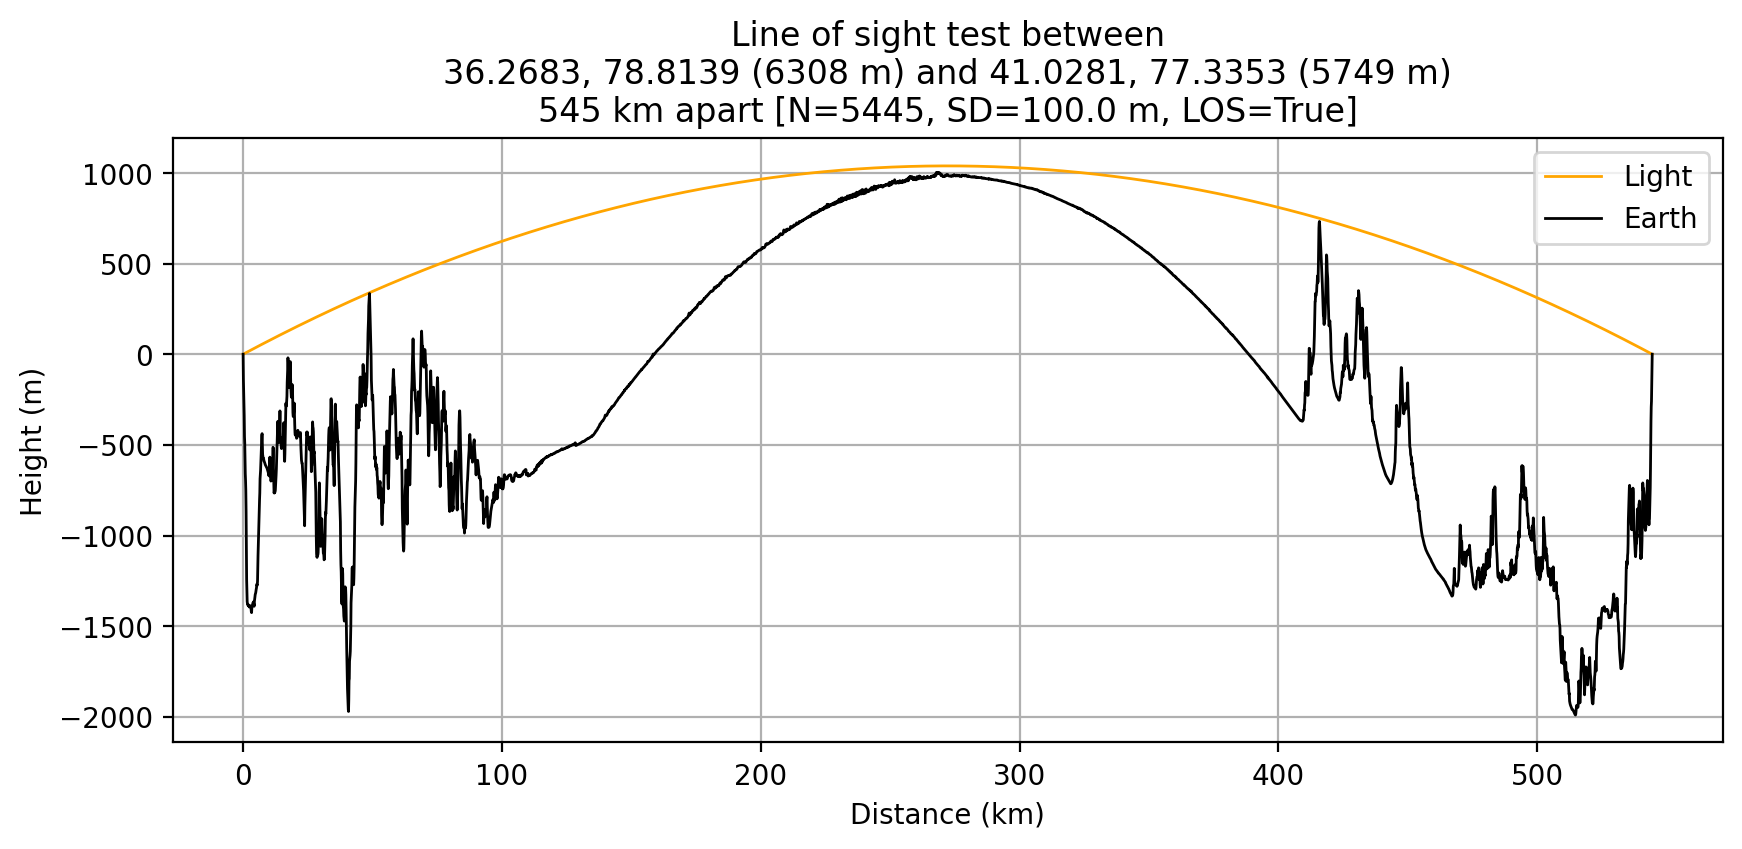

In [6]:
import commonFunctions as func

O = func.Summit(36.2683, 78.8139, 6308) #BeyondHorizon: 42.414550, 2.133390, 2820 #Actual: 42.414475, 2.133279, 2827
T = func.Summit(41.0281, 77.3353, 5749) # 44.998, 6.331, 3881

LOS = func.LineOfSight(O, T, forceFull=True, sampleDist=0.1)
print(LOS.surfaceDistance)
LOS.plot('Longest_Photo_R=5.6.png')


483948.05155818886


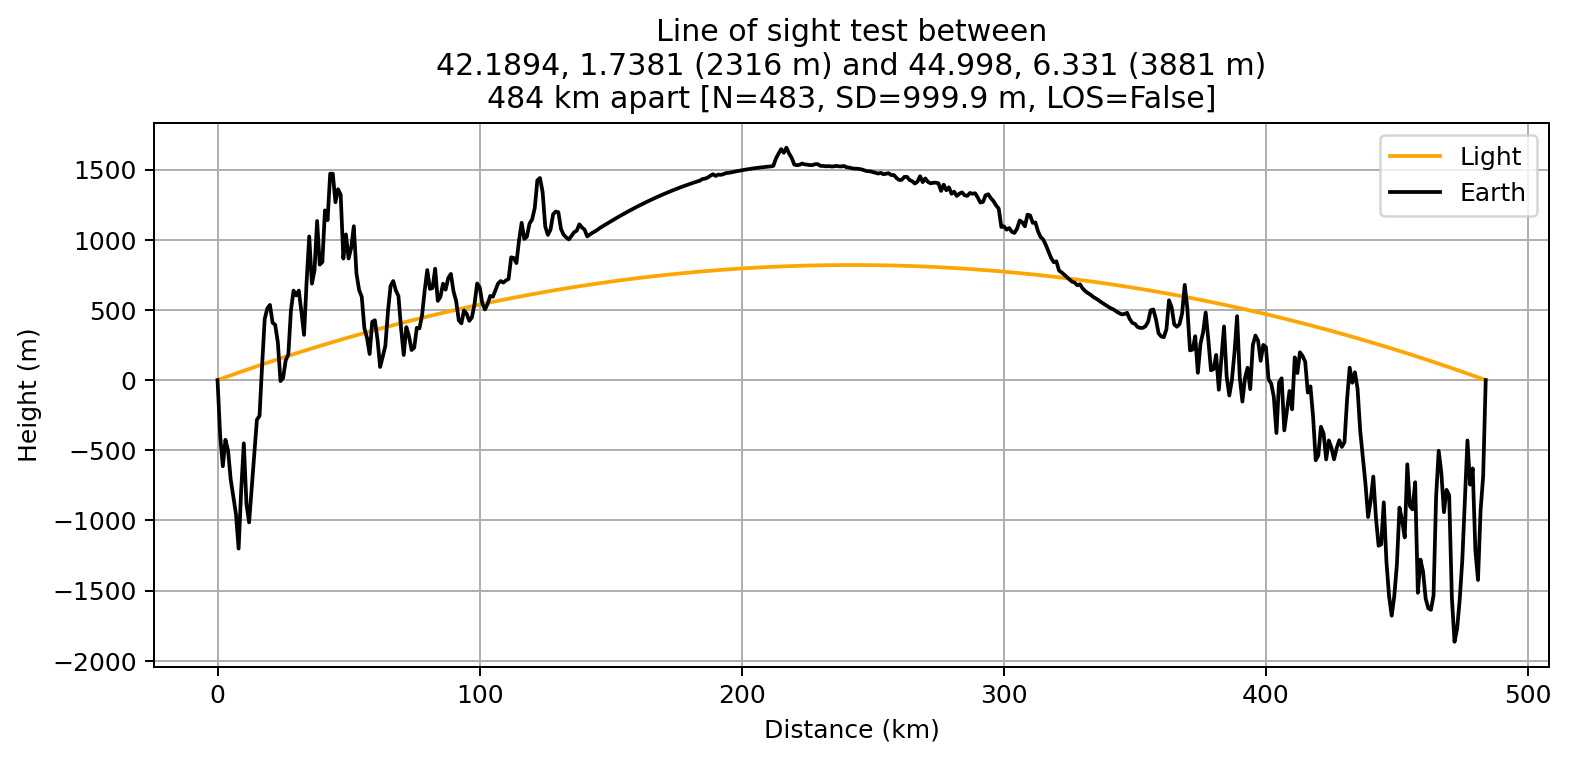

In [15]:
import commonFunctions as func

O = func.Summit(42.1894, 1.7381, 2316)
T = func.Summit(44.998, 6.331, 3881)   

LOS = func.LineOfSight(O, T, forceFull=True)
print(LOS.surfaceDistance)
LOS.plot()


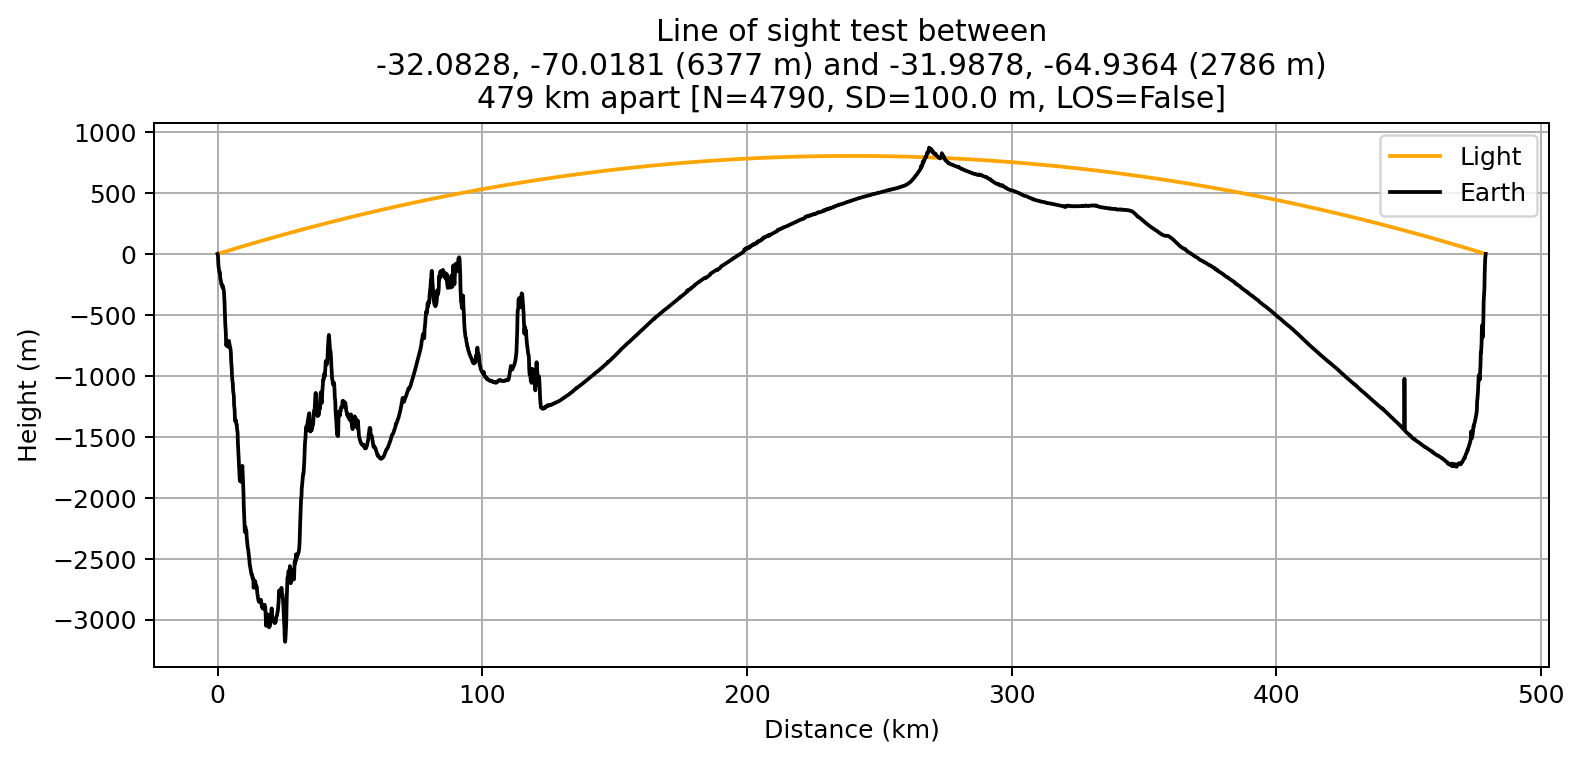

In [11]:
LOS = func.LineOfSight(O, T, sampleDist=0.1, forceFull=True)
LOS.plot()

In [21]:
summits = pd.read_csv('../dataSources/baseDatasets/prominenceSummits/all_prm-100ft.txt')
summits = summits.query('prominence > 1000')
summits = summits.sort_values('elevation', ascending=False)

summits = summits.apply(lambda s: func.Summit(
    s.latitude, s.longitude, s.elevation, id=s.id, prominence=s.prominence), axis=1).tolist()

In [22]:
len(summits)

6839

In [25]:
linesOfSight = []
for observerId, observer in enumerate(summits):
    
    candidateTargets = summits[observerId+1:]
    
    losCandidates = [func.LineOfSight(observer, target, numPoints=1, skipProcessing=True) for target in candidateTargets]
    
    [linesOfSight.append(los) for los in losCandidates if los.passesMaxHorizonDistanceTest()]
    
    if observerId%500 == 0:
        print(observerId)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800


In [26]:
print(len(linesOfSight))

67835


In [ ]:
losCandidates = linesOfSight

linesOfSight_R1 = []

numLosCandidateBatches = int(math.ceil(len(losCandidates)/func.apiLimit))
for batchId in range(numLosCandidateBatches):
    losCandidateBatchMidLats = []
    losCandidateBatchMidLngs = []
    losCandidateBatch = losCandidates[batchId*func.apiLimit:(batchId+1)*func.apiLimit]

    # Find latitudes and longitudes for midpoints
    for losCandidate in losCandidateBatch:
        latitudeAsList, longitudeAsList = losCandidate.getLatitudesAndLongitudes()
        losCandidateBatchMidLats.append(latitudeAsList[0])
        losCandidateBatchMidLngs.append(longitudeAsList[0])

    # Find elevations for midpoints
    losCandidateBatchMidElvs = func.getElevation(','.join(map(str, losCandidateBatchMidLats)), 
                                                 ','.join(map(str, losCandidateBatchMidLngs)))

    losCandidate = None
    for losCandidateBatchId in range(len(losCandidateBatch)):
        
        losCandidate = func.LineOfSight(observer, 
                                        losCandidateBatch[losCandidateBatchId].target, 
                                        losPoints = [func.LosPoint(losCandidateBatchMidLats[losCandidateBatchId],
                                                                   losCandidateBatchMidLngs[losCandidateBatchId],
                                                                   losCandidateBatchMidElvs[losCandidateBatchId])])
        
        if losCandidate.passesLineOfSightTest():
        
            linesOfSight_R1.append(losCandidate)